# Tutorial Part 15: Synthetic Feasibility

Synthetic feasibility is a problem when running large scale enumerations.  Ofen molecules that are enumerated are very difficult to make and thus not worth inspection even if their other chemical properties are good in silico.  This tutorial goes through how to train the [ScScore](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00622) model [1].

The idea of the model is to train on pairs of molecules where one molecule is "more complex" than the other.  The neural network then can make scores which attempt to keep this pairwise ordering of molecules.  The final result is a model which can give a relative complexity of a molecule.

The paper trains on every reaction in reaxys, declaring products more complex than reactions.  Since this training set is prohibitively expensive we will instead train on arbitrary molecules declaring one more complex if it's SMILES string is longer.  In the real world you can use whatever measure of complexity makes sense for the project.

In this tutorial, we'll use the Tox21 dataset to train our simple synthetic feasibility model.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/15_Synthetic_Feasibility_Scoring.ipynb)


## Setup

We recommend you run this tutorial on Google colab. You'll need to run the following commands to set up your colab environment to run the notebook.

In [1]:
%tensorflow_version 1.x
!curl -Lo deepchem_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import deepchem_installer
%time deepchem_installer.install(version='2.3.0')
import deepchem as dc

TensorFlow 1.x selected.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2814  100  2814    0     0  65441      0 --:--:-- --:--:-- --:--:-- 65441


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing deepchem
done
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



deepchem-2.3.0 installation finished!


CPU times: user 2.54 s, sys: 556 ms, total: 3.1 s
Wall time: 4min 20s


In [2]:
# Lets get some molecules to play with

from deepchem.molnet.load_function import tox21_datasets
tasks, datasets, transformers = tox21_datasets.load_tox21(featurizer='Raw', split=None, reload=False)
molecules = datasets[0].X

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/tox21.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 4.905 s
TIMING: dataset construction took 5.264 s
Loading dataset from disk.
TIMING: dataset construction took 0.392 s
Loading dataset from disk.


# Make The Datasets

Because ScScore is trained on relative complexities we have our `X` tensor in our dataset has 3 dimensions `(sample_id, molecule_id, features)`.  the 1st dimension molecule_id is in \[0, 1\], because a sample is a pair of molecules.  The label is 1 if the zeroth molecule is more complex than the first molecule. The function `create_dataset` we introduce below pulls random pairs of smiles strings out of a given list and ranks them according to this complexity measure.

In the real world you could use purchase cost, or number of reaction steps required as your complexity score. 

In [0]:
from rdkit import Chem
import random
from deepchem.feat import CircularFingerprint
import deepchem as dc
import numpy as np


def create_dataset(fingerprints, smiles_lens, ds_size=100000):
    """
    m1: list of np.Array
        fingerprints for molecules
    m2: list of int
        length of a molecules SMILES string
    
    returns:
        dc.data.Dataset for input into ScScore Model
        
    Dataset.X
        shape is (sample_id, molecule_id, features)
    Dataset.y
        shape is (sample_id,)
        values is 1 if the 0th index molecule is more complex
                  0 if the 1st index molecule is more complex
    """
    X, y = [], []
    all_data = list(zip(fingerprints, smiles_lens))
    while len(y) < ds_size:
        i1 = random.randrange(0, len(smiles_lens))
        i2 = random.randrange(0, len(smiles_lens))
        m1 = all_data[i1]
        m2 = all_data[i2]
        if m1[1] == m2[1]:
            continue
        if m1[1] > m2[1]:
            y.append(1.0)
        else:
            y.append(0.0)
        X.append([m1[0], m2[0]])
    return dc.data.NumpyDataset(np.array(X), np.expand_dims(np.array(y), axis=1))


With our complexity ranker in place we can now construct our dataset. Let's start by loading the molecules in the Tox21 dataset into memory. We split the dataset at this stage to ensure that the training and test set have non-overlapping sets of molecules.

In [0]:
# Lets split our dataset into a train set and a test set
molecule_ds = dc.data.NumpyDataset(np.array(molecules))
splitter = dc.splits.RandomSplitter()
train_mols, test_mols = splitter.train_test_split(molecule_ds)

We'll featurize all our molecules with the ECFP fingerprint with chirality (matching the source paper), and will then construct our pairwise dataset using the code from above.

In [0]:
# In the paper they used 1024 bit fingerprints with chirality
n_features=1024
featurizer = dc.feat.CircularFingerprint(size=n_features, radius=2, chiral=True)
train_features = featurizer.featurize(train_mols.X)
train_smileslen = [len(Chem.MolToSmiles(x)) for x in train_mols.X]
train_dataset = create_dataset(train_features, train_smileslen)

Now that we have our dataset created, let's train a `ScScoreModel` on this dataset.

In [6]:
from deepchem.models import ScScoreModel
# Now to create the model and train it
model = ScScoreModel(n_features=n_features)
model.fit(train_dataset, nb_epoch=20)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.









0.0

# Model Performance

Lets evaluate how well the model does on our holdout molecules.  The SaScores should track the length of SMILES strings from never before seen molecules.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
mol_scores = model.predict_mols(test_mols.X)
smiles_lengths = [len(Chem.MolToSmiles(x)) for x in test_mols.X]

Let's now plot the length of the smiles string of the molecule against the SaScore using matplotlib.

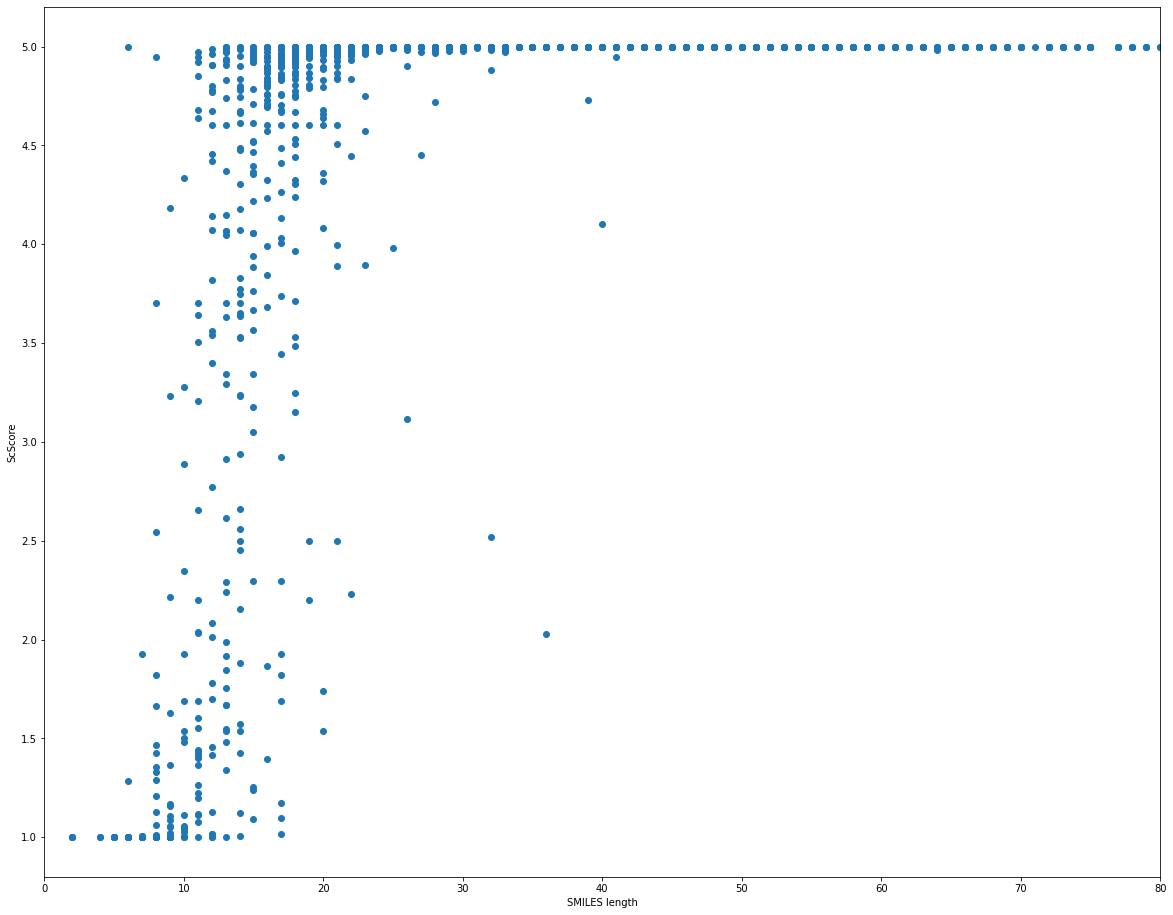

In [9]:
plt.figure(figsize=(20,16))
plt.scatter(smiles_lengths, mol_scores)
plt.xlim(0,80)
plt.xlabel("SMILES length")
plt.ylabel("ScScore")
plt.show()

As we can see the model generally tracks SMILES length.  It has good enrichment between 8 and 30 characters and gets both small and large SMILES strings extremes dead on.

Now you can train your own models on more meaningful metrics than SMILES length!

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!


# Bibliography:

[1] https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00622